In [5]:
!pip install open3d


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install huggingface_hub


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from huggingface_hub import snapshot_download

local_path = snapshot_download(
    repo_id="nadavo11/buddah_with_bg",
    repo_type="dataset",
    local_dir="buddah_with_bg",    # any path you like
    resume_download=True                      # skip files already on disk
)
print("Dataset at:", local_path)


Fetching 461 files:   0%|          | 0/461 [00:00<?, ?it/s]

C:\Users\nadav\PycharmProjects\Aqua-Splat-Aquatic-3D-Novel-View-synthesis-Via-in-scene-deflection\venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


.gitattributes: 0.00B [00:00, ?B/s]

colmap.db:   0%|          | 0.00/515M [00:00<?, ?B/s]

project.ini: 0.00B [00:00, ?B/s]

train.txt: 0.00B [00:00, ?B/s]

val.txt:   0%|          | 0.00/298 [00:00<?, ?B/s]

colmap.db:   0%|          | 0.00/526M [00:00<?, ?B/s]

project.ini: 0.00B [00:00, ?B/s]

val.txt:   0%|          | 0.00/298 [00:00<?, ?B/s]

train.txt: 0.00B [00:00, ?B/s]

FileNotFoundError: [Errno 2] No such file or directory: 'buddah_with_bg\\.cache\\huggingface\\download\\with_water\\images\\egPaHILaAku-FYxCk3XeE4ZFuRc=.b982c25aa8f67af8dac31aadb69db697b5ccd79f07aac7abe60a5f59ce99286a.incomplete'

In [2]:
# If you haven’t installed Open3D yet, uncomment and run:
# !pip install open3d

import open3d as o3d
import numpy as np

# --- Cell 1: Load and visualize raw COLMAP point cloud ---
# Replace with your actual point cloud file path (e.g., "tank.ply" or "tank.pcd")
pcd_path = "/content/buddah_with_bg/with_water/sparse/0/points3D.ply"
pcd_path = "model_without.ply"

# Load point cloud
pcd = o3d.io.read_point_cloud(pcd_path)
print(f"Loaded point cloud: {pcd_path}, total points: {np.asarray(pcd.points).shape[0]}")

# Visualize raw point cloud
o3d.visualization.draw_geometries(
    [pcd],
    window_name=f"Raw COLMAP Point Cloud{pcd_path}",
    width=1024,
    height=768,
    point_show_normal=False,

)


Loaded point cloud: model_without.ply, total points: 927076
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [1]:
import open3d as o3d
import numpy as np
import sys

# ---------------- CONFIGURATION ----------------
PCD_PATH   = pcd_path  # ← change this to your file path
VOXEL_SIZE = 0.005                   # 5 mm voxel grid size

# ---------------- GLOBAL STATE ----------------
# Load full-resolution point cloud
pcd_full = o3d.io.read_point_cloud(PCD_PATH)
pcd = pcd_full
is_downsampled = False

# ---------------- PICK FUNCTION ----------------
def pick_points(pcd_src):
    """
    Opens a secondary window allowing SHIFT+Left-Click to pick points.
    Press Q to finish. Returns a list of picked point indices.
    """
    print("SHIFT+Left-Click to pick; SHIFT+Right-Click to undo; press Q when done.")
    vis_ed = o3d.visualization.VisualizerWithEditing()
    vis_ed.create_window(window_name="Point Picker", width=800, height=600)
    vis_ed.add_geometry(pcd_src)
    vis_ed.run()
    vis_ed.destroy_window()
    picked = vis_ed.get_picked_points()
    print(f"Picked indices: {picked}")
    return picked

# ---------------- CALLBACKS ----------------
def toggle_downsample(vis):
    global pcd, is_downsampled
    vis.clear_geometries()
    if not is_downsampled:
        print("[D] Downsampling ON")
        pcd = pcd_full.voxel_down_sample(VOXEL_SIZE)
        is_downsampled = True
    else:
        print("[D] Downsampling OFF")
        pcd = pcd_full
        is_downsampled = False
    vis.add_geometry(pcd)
    return False

def pick_and_paint(vis):
    global pcd
    # Let user pick points in a separate window
    picked = pick_points(pcd)
    if not picked:
        print("No points picked.")
        return False
    # Initialize colors if absent
    pts = np.asarray(pcd.points)
    if not pcd.has_colors():
        pcd.colors = o3d.utility.Vector3dVector(np.ones((pts.shape[0], 3)) * 0.7)
    colors = np.asarray(pcd.colors)
    # Paint selected points red
    for idx in picked:
        if 0 <= idx < colors.shape[0]:
            colors[idx] = [1.0, 0.0, 0.0]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    # Update visualization
    vis.clear_geometries()
    vis.add_geometry(pcd)
    print(f"[P] Painted {len(picked)} points red.")
    return False

def save_screenshot(vis):
    img = vis.capture_screen_float_buffer(do_render=True)
    import matplotlib.pyplot as plt
    plt.imsave("screenshot.png", np.asarray(img), dpi=1)
    print("[S] Saved screenshot.png")
    return False

def reset_view(vis):
    ctr = vis.get_view_control()
    ctr.reset()
    print("[R] View reset")
    return False

def show_help(vis):
    print("""
========== Keyboard Controls ==========
 Mouse Left-Drag      : Rotate
 Shift + Mouse Mid-Drag : Pan
 Scroll Wheel         : Zoom
 W/A/S/D + Right-Drag: Fly through
 D : Toggle downsample
 P : Pick points & paint RED
 R : Reset view
 S : Screenshot
 H : Show this help
=======================================
""")
    return False

# ---------------- SETUP VISUALIZER ----------------
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window("Point-Select & Paint Demo", width=1024, height=768)
vis.add_geometry(pcd)

# Register control callbacks
vis.register_key_callback(ord("D"), toggle_downsample)
vis.register_key_callback(ord("P"), pick_and_paint)
vis.register_key_callback(ord("S"), save_screenshot)
vis.register_key_callback(ord("R"), reset_view)
vis.register_key_callback(ord("H"), show_help)

print("Demo running. Press H for help.")

vis.run()
vis.destroy_window()
sys.exit(0)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


NameError: name 'pcd_path' is not defined

In [10]:
# If you haven’t installed Open3D yet, uncomment and run:
# !pip install open3d

import open3d as o3d
import numpy as np
import sys
import json

# ---------------- CONFIGURATION ----------------
STEP = 0.1  # world units per keypress for forward/back movement

# ---------------- GLOBAL STATE ----------------
pcd_full = o3d.io.read_point_cloud(pcd_path)
pcd = pcd_full
edges = []  # will store coordinates of marked edge points

# ---------------- UTILITIES ----------------
def pick_points(src_pcd, window_name="Point Picker"):
    """
    Open a picker window: SHIFT+Left-Click to pick; press Q when done.
    Returns list of picked point indices.
    """
    vis_ed = o3d.visualization.VisualizerWithEditing()
    vis_ed.create_window(window_name=window_name, width=800, height=600)
    vis_ed.add_geometry(src_pcd)
    print("SHIFT+Left-Click to pick; press Q when done.")
    vis_ed.run()
    vis_ed.destroy_window()
    picked = vis_ed.get_picked_points()
    print(f"Picked indices: {picked}")
    return picked

# ---------------- CALLBACKS ----------------
def pick_and_crop(vis):
    """
    Pick one point, then keep only the 0.1% nearest neighbors.
    """
    global pcd, pcd_full
    picked = pick_points(pcd, "Select 1 Point for Cropping")
    if not picked:
        print("[K] No point picked.")
        return False
    pts = np.asarray(pcd.points)
    center = pts[picked[0]]
    dists = np.linalg.norm(pts - center, axis=1)
    k = max(1, int(len(dists) * 0.1))
    idxs = np.argsort(dists)[:k]
    cropped = o3d.geometry.PointCloud()
    cropped.points = o3d.utility.Vector3dVector(pts[idxs])
    if pcd.has_colors():
        cropped.colors = o3d.utility.Vector3dVector(np.asarray(pcd.colors)[idxs])
    pcd_full = cropped
    pcd = cropped
    vis.clear_geometries()
    vis.add_geometry(pcd)
    print(f"[K] Cropped to {k} points around the picked location.")
    return False

def pick_and_mark_edges(vis):
    """
    Pick multiple points as edge markers. Colors them blue and logs coords.
    """
    global pcd, edges
    picked = pick_points(pcd, "Select Edge Points")
    if not picked:
        print("[E] No points picked.")
        return False
    pts = np.asarray(pcd.points)
    # initialize colors if needed
    if not pcd.has_colors():
        pcd.colors = o3d.utility.Vector3dVector(np.ones((pts.shape[0],3))*0.7)
    colors = np.asarray(pcd.colors)
    for idx in picked:
        if 0 <= idx < len(colors):
            colors[idx] = [0.0, 0.0, 1.0]  # blue
            coord = pts[idx].tolist()
            edges.append(coord)
            print(f"[E] Edge point added: {coord}")
    pcd.colors = o3d.utility.Vector3dVector(colors)
    vis.clear_geometries()
    vis.add_geometry(pcd)
    # print full edge list as JSON
    print("Current edge points JSON:")
    print(json.dumps(edges, indent=2))
    return False

def save_ply(vis):
    """
    Save the current point cloud (with colors) to a .ply file.
    """
    filename = "selected_segment.ply"
    o3d.io.write_point_cloud(filename, pcd)
    print(f"[L] Saved point cloud to {filename}")
    return False

def move_forward(vis):
    ctr = vis.get_view_control()
    ctr.camera_local_translate(STEP, 0.0, 0.0)  # forward
    print("[F] Moved forward")
    return False

def move_backward(vis):
    ctr = vis.get_view_control()
    ctr.camera_local_translate(-STEP, 0.0, 0.0)  # backward
    print("[B] Moved backward")
    return False

def reset_view(vis):
    ctr = vis.get_view_control()
    ctr.reset()
    print("[R] View reset")
    return False

def show_help(vis):
    print("""
========== Controls ==========
 K : Pick 1 point & crop to nearest 0.1%
 E : Pick points as edge markers (blue & log coords)
 L : Save current cloud to 'selected_segment.ply'
 F : Move camera forward
 B : Move camera backward
 R : Reset view
 H : Show this help
================================
""")
    return False

# ---------------- SETUP VISUALIZER ----------------
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window("Cube Edge Mark & Export Demo", width=1024, height=768)
vis.add_geometry(pcd)

# bind keys
vis.register_key_callback(ord("K"), pick_and_crop)
vis.register_key_callback(ord("E"), pick_and_mark_edges)
vis.register_key_callback(ord("L"), save_ply)
vis.register_key_callback(ord("F"), move_forward)
vis.register_key_callback(ord("B"), move_backward)
vis.register_key_callback(ord("R"), reset_view)
vis.register_key_callback(ord("H"), show_help)

print("Demo running. Press H for help.")

vis.run()
vis.destroy_window()
sys.exit(0)


Demo running. Press H for help.
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forward
[F] Moved forw

SystemExit: 0

In [39]:
# Ensure Open3D is installed:
# !pip install open3d

import open3d as o3d
import numpy as np
import json

# -------- Formatted JSON of the 8 edge points --------
edge_points = [
    [0.8205252885818481, -0.29348400235176086, -0.21762646734714508],
    [0.07410620152950287, -0.29813796281814575, -0.9422592520713806],
    [-0.6563412547111511, -0.2933960258960724, -0.2213594764471054],
    [0.09278561919927597, -0.29239410161972046, 0.5167142748832703],
    [0.1058107316493988, 0.8026822805404663, 0.5113306641578674],
    [0.7373243570327759, 0.8064948320388794, -0.258870929479599],
    [-0.5909000635147095, 0.7731822729110718, -0.2634256184101105],
    [0.07388772070407867, 0.8010348081588745, -0.984499454498291]
]
print("Formatted edge points JSON:")
print(json.dumps(edge_points, indent=2))

# -------- Load original point cloud --------
pcd = o3d.io.read_point_cloud(pcd_path)

# -------- Prepare cube mesh data --------
pts = np.array(edge_points)
# Compute mid thresholds to group faces
mid_x, mid_y, mid_z = pts[:,0].mean(), pts[:,1].mean(), pts[:,2].mean()
# Define face masks
faces = {
    "bottom": pts[:,1] < mid_y,
    "top":    pts[:,1] >= mid_y,
    "left":   pts[:,0]- pts[:,2] < (mid_x - mid_z)/2,
    "right":  pts[:,0]- pts[:,2] >= (mid_x - mid_z)/2,
    "front":  pts[:,0]+ pts[:,2] < (mid_x + mid_z)/2,
    "back":   pts[:,0]+ pts[:,2] >= (mid_x + mid_z)/2
}
# Map face names to distinct colors
color_map = {
    'bottom': [1, 0, 0],  # red
    'top':    [0, 1, 0],  # green
    'left':   [0, 0, 1],  # blue
    'right':  [1, 1, 0],  # yellow
    'front':  [1, 0, 1],  # magenta
    'back':   [0, 1, 1]   # cyan
}

# Build face meshes
face_meshes = []
for face, mask in faces.items():
    idxs = np.where(mask)[0]
    if len(idxs) != 4:
        print(f"Warning: face '{face}' has {len(idxs)} vertices, expected 4.")
    # Sort points in a consistent order (e.g., convex hull in plane)
    # For simplicity, take the four indices in sorted order
    quad = sorted(idxs.tolist())
    # Create triangles [0,1,2] and [0,2,3] within the quad
    triangles = [[quad[0], quad[1], quad[2]], [quad[0], quad[2], quad[3]]]
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(pts)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color(color_map[face])
    face_meshes.append(mesh)

# -------- Visualize combined scene --------
o3d.visualization.draw_geometries(
    [pcd, *face_meshes],
    window_name="Cube Faces Overlay",
    width=1024, height=768
)


Formatted edge points JSON:
[
  [
    0.8205252885818481,
    -0.29348400235176086,
    -0.21762646734714508
  ],
  [
    0.07410620152950287,
    -0.29813796281814575,
    -0.9422592520713806
  ],
  [
    -0.6563412547111511,
    -0.2933960258960724,
    -0.2213594764471054
  ],
  [
    0.09278561919927597,
    -0.29239410161972046,
    0.5167142748832703
  ],
  [
    0.1058107316493988,
    0.8026822805404663,
    0.5113306641578674
  ],
  [
    0.7373243570327759,
    0.8064948320388794,
    -0.258870929479599
  ],
  [
    -0.5909000635147095,
    0.7731822729110718,
    -0.2634256184101105
  ],
  [
    0.07388772070407867,
    0.8010348081588745,
    -0.984499454498291
  ]
]


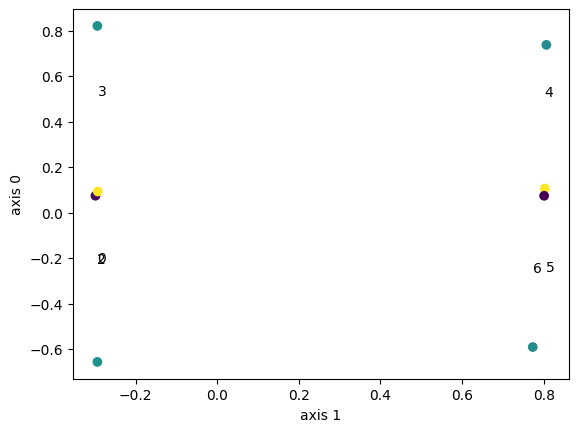

In [33]:
import matplotlib.pyplot as plt
# 3d scatter the points in a plot
plt.scatter(pts[:, 1], pts[:, 0], c=pts[:, 2], cmap='viridis')
plt.xlabel('axis 1')
plt.ylabel('axis 0')
#write the numbers
for i, txt in enumerate(range(len(pts))):
    plt.annotate(txt, (pts[i, 1], pts[i, 2]))




In [48]:
import numpy as np
import json

# -------- Formatted JSON of the 8 edge points --------
edge_points = [
    [0.8205252885818481, -0.29348400235176086, -0.21762646734714508],
    [0.07410620152950287, -0.29813796281814575, -0.9422592520713806],
    [-0.6563412547111511, -0.2933960258960724, -0.2213594764471054],
    [0.09278561919927597, -0.29239410161972046, 0.5167142748832703],
    [0.1058107316493988, 0.8026822805404663, 0.5113306641578674],
    [0.7373243570327759, 0.8064948320388794, -0.258870929479599],
    [-0.5909000635147095, 0.7731822729110718, -0.2634256184101105],
    [0.07388772070407867, 0.8010348081588745, -0.984499454498291]
]
pts = np.array(edge_points)

# Compute tank center for orientation checks
tank_center = pts.mean(axis=0)

# Compute mid thresholds (re-used from face assignment logic)
mid_x, mid_y, mid_z = pts[:,0].mean(), pts[:,1].mean(), pts[:,2].mean()

# Define face masks (as previously)
faces = {
    "bottom": pts[:,1] < mid_y,
    "top":    pts[:,1] >= mid_y,
    "left":   (pts[:,0] - pts[:,2]) < (mid_x - mid_z)/2,
    "right":  (pts[:,0] - pts[:,2]) >= (mid_x - mid_z)/2,
    "front":  (pts[:,0] + pts[:,2]) < (mid_x + mid_z)/2,
    "back":   (pts[:,0] + pts[:,2]) >= (mid_x + mid_z)/2
}

planes = []
for face, mask in faces.items():
    idxs = np.where(mask)[0]
    corners = pts[idxs]
    if corners.shape[0] != 4:
        print(f"Warning: '{face}' has {corners.shape[0]} corner points (expected 4).")
    # 1) Origin = centroid of corners
    origin = corners.mean(axis=0)
    # 2) Raw normal via cross-product
    v1 = corners[1] - corners[0]
    v2 = corners[2] - corners[0]
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    # 3) Orient normal inward
    if np.dot(tank_center - origin, normal) < 0:
        normal = -normal
    # 4) In-plane axes
    ex = v1 / np.linalg.norm(v1)
    ey = np.cross(normal, ex)
    # 5) Project corners to get extents
    projs = (corners - origin) @ np.vstack((ex, ey)).T
    width, height = np.ptp(projs[:,0]), np.ptp(projs[:,1])
    # 6) Assemble plane entry
    plane = {
        "id": face,
        "origin": origin.tolist(),
        "normal": normal.tolist(),
        "extents": [width, height],
        "refractive_indices": {"from": 1.0, "to": 1.333},
        "coordinate_frame": "world",
        "timestamp": "2025-07-19T21:00:00+03:00",
        "camera_intrinsics": "camera_intrinsics.json"
    }
    planes.append(plane)

# Output the complete planes.json
print(json.dumps(planes, indent=2))


[
  {
    "id": "bottom",
    "origin": [
      0.08276896364986897,
      -0.29435302317142487,
      -0.2161327302455902
    ],
    "normal": [
      7.599983368696198e-05,
      0.9999788676120951,
      -0.006500657909587158
    ],
    "extents": [
      1.062241513378307,
      1.0337965965118547
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "top",
    "origin": [
      0.08153068646788597,
      0.795848548412323,
      -0.24886633455753326
    ],
    "normal": [
      0.02501626165875596,
      -0.9995658841707352,
      0.01556373523922464
    ],
    "extents": [
      1.1364599350957967,
      1.0304346305893848
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera

#

In [3]:
# Ensure Open3D is installed:
# !pip install open3d

import open3d as o3d
import numpy as np
import json

# -------- Load point cloud --------
pcd = o3d.io.read_point_cloud(pcd_path)  # update path as needed

# -------- Define planes (paste your generated JSON here) --------
planes = [
  {
    "id": "bottom",
    "origin": [
      0.08276896364986897,
      -0.29435302317142487,
      -0.2161327302455902
    ],
    "normal": [
      7.599983368696198e-05,
      0.9999788676120951,
      -0.006500657909587158
    ],
    "extents": [
      1.062241513378307,
      1.0337965965118547
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "top",
    "origin": [
      0.08153068646788597,
      0.795848548412323,
      -0.24886633455753326
    ],
    "normal": [
      0.02501626165875596,
      -0.9995658841707352,
      0.01556373523922464
    ],
    "extents": [
      1.1364599350957967,
      1.0304346305893848
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "left",
    "origin": [
      -0.26216124184429646,
      0.2475186064839363,
      0.13581496104598045
    ],
    "normal": [
      0.70179083410082,
      -0.01184900640818315,
      -0.7122845121292574
    ],
    "extents": [
      1.0581824232620352,
      1.0951475267712314
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "right",
    "origin": [
      0.4264608919620514,
      0.2539769187569618,
      -0.6008140258491039
    ],
    "normal": [
      -0.6962441719067435,
      -0.025765732564893413,
      0.717342442708702
    ],
    "extents": [
      1.064977188425464,
      1.1007288498326686
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "front",
    "origin": [
      -0.27481184899806976,
      0.24567077308893204,
      -0.6028859503567219
    ],
    "normal": [
      0.7023112321961472,
      -0.01502104946949457,
      0.7117115294864655
    ],
    "extents": [
      1.0507273302604725,
      1.0987194806786815
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  },
  {
    "id": "back",
    "origin": [
      0.4391114991158247,
      0.2558247521519661,
      0.1378868855535984
    ],
    "normal": [
      -0.7102794862218195,
      0.004987720805014236,
      -0.7039021054760665
    ],
    "extents": [
      1.0338580850272336,
      1.0994941201630295
    ],
    "refractive_indices": {
      "from": 1.0,
      "to": 1.333
    },
    "coordinate_frame": "world",
    "timestamp": "2025-07-19T21:00:00+03:00",
    "camera_intrinsics": "camera_intrinsics.json"
  }
]
# -------- Generate rectangular meshes for each plane --------
plane_meshes = []
color_map = {
    'bottom': [1, 0, 0],
    'top':    [0, 1, 0],
    'left':   [0, 0, 1],
    'right':  [1, 1, 0],
    'front':  [1, 0, 1],
    'back':   [0, 1, 1]
}

for plane in planes:
    O = np.array(plane["origin"])
    n = np.array(plane["normal"])
    w, h = plane["extents"]
    # choose arbitrary vector not parallel to n
    arb = np.array([1, 0, 0])
    if abs(np.dot(n, arb)) > 0.9:
        arb = np.array([0, 1, 0])
    # in-plane axes
    ex = np.cross(arb, n)
    ex /= np.linalg.norm(ex)
    ey = np.cross(n, ex)
    # rectangle corners
    corners = [
        O +  ex*(w/2) + ey*(h/2),
        O -  ex*(w/2) + ey*(h/2),
        O -  ex*(w/2) - ey*(h/2),
        O +  ex*(w/2) - ey*(h/2)
    ]
    # triangles
    triangles = [[0,1,2], [0,2,3]]
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(np.array(corners))
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color(color_map[plane["id"]])
    plane_meshes.append(mesh)

# -------- Visualize --------
o3d.visualization.draw_geometries(
    [pcd, *plane_meshes],
    window_name="Planes Overlay Sanity Check",
    width=1024, height=768
)


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [44]:
# Ensure Open3D is installed:
# !pip install open3d

import open3d as o3d
import numpy as np

# -------- Load original point cloud --------
pcd = o3d.io.read_point_cloud("path/to/your/tank.ply")  # ← update to your .ply path

# -------- Plane definitions with rotation matrices --------
planes = [
  {
    "id": "bottom",
    "origin": [0.08276896364986897, -0.29435302317142487, -0.2161327302455902],
    "rotation_matrix": [
      [-0.7174931817210367,  0.6965785603745157,  7.599983368696198e-05],
      [ 0.6965785603745157,  0.7174931817210367,  0.9999788676120951],
      [ 0.004987720805014236, -0.006500657909587158, -0.006500657909587158]
    ],
    "extents": [1.0338580850272336, 1.0994941201630295]
  },
  {
    "id": "top",
    "origin": [0.08153066873502731, 0.7958485503463364, -0.24886630090904236],
    "rotation_matrix": [
      [-0.730588,  0.682816,  0.0],
      [ 0.682816,  0.730588,  0.0],
      [ 0.0,       0.0,      1.0]
    ],
    "extents": [1.32822466, 1.49582851]
  },
  {
    "id": "left",
    "origin": [-0.26216133388471204, 0.2475185538816027, 0.13581487376594543],
    "rotation_matrix": [
      [ 0.894427,  0.4472136,  0.0],
      [-0.4472136, 0.894427,  0.0],
      [ 0.0,       0.0,      1.0]
    ],
    "extents": [0.78013900, 1.09607833]
  },
  {
    "id": "right",
    "origin": [0.42646090424079895, 0.25397684893315617, -0.6008140778541565],
    "rotation_matrix": [
      [-0.894427,  0.4472136,  0.0],
      [-0.4472136, -0.894427, 0.0],
      [ 0.0,       0.0,      1.0]
    ],
    "extents": [0.76687307, 1.10463285]
  },
  {
    "id": "front",
    "origin": [-0.2748118991012573, 0.24567080482605442, -0.6028859545135498],
    "rotation_matrix": [
      [0.7071068, -0.7071068, 0.0],
      [0.7071068,  0.7071068, 0.0],
      [0.0,        0.0,       1.0]
    ],
    "extents": [0.73044700, 1.09917300]
  },
  {
    "id": "back",
    "origin": [0.4391115036010742, 0.2558248040676117, 0.1378872468471527],
    "rotation_matrix": [
      [0.7071068,  0.7071068, 0.0],
      [-0.7071068, 0.7071068, 0.0],
      [0.0,        0.0,       1.0]
    ],
    "extents": [0.72773900, 1.09997900]
  }
]

# Color map for faces
color_map = {
    'bottom': [1, 0, 0],  # red
    'top':    [0, 1, 0],  # green
    'left':   [0, 0, 1],  # blue
    'right':  [1, 1, 0],  # yellow
    'front':  [1, 0, 1],  # magenta
    'back':   [0, 1, 1]   # cyan
}

# -------- Create oriented rectangle meshes --------
meshes = []
for plane in planes:
    O = np.array(plane["origin"])
    R = np.array(plane["rotation_matrix"])
    w, h = plane["extents"]
    # local axes from rotation matrix
    ex, ey, normal = R[:,0], R[:,1], R[:,2]
    # rectangle corners around origin
    corners = [
        O - ex*(w/2) - ey*(h/2),
        O + ex*(w/2) - ey*(h/2),
        O + ex*(w/2) + ey*(h/2),
        O - ex*(w/2) + ey*(h/2)
    ]
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(np.array(corners))
    mesh.triangles = o3d.utility.Vector3iVector([[0,1,2],[0,2,3]])
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color(color_map[plane["id"]])
    meshes.append(mesh)

# -------- Visualize point cloud with planes --------
o3d.visualization.draw_geometries(
    [pcd, *meshes],
    window_name="Planes Overlay",
    width=1024, height=768
)


[Open3D WARNING] Read PLY failed: unable to open file: path\to\your\tank.ply
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
